In [5]:
# =============================================================================
# --- Tahap 1: Inisialisasi dan Pemuatan Semua Hasil Prediksi ---
# =============================================================================

import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Tentukan path ke folder 'predictions' Anda
PATH_PREDICTIONS = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\predictions'

# Daftar file hasil prediksi yang akan dimuat
prediction_files = {
    'lgbm_temporal': 'lgbm_results.parquet',
    'lstm_temporal': 'lstm_results_revised.parquet',
    'lgbm_spatial': 'lgbm_results_spatial.parquet',
    'lstm_spatial': 'lstm_results_spatial.parquet'
}

# Muat semua file ke dalam dictionary of DataFrames
dfs = {}
print("--- Memuat Hasil Prediksi ---")
for key, filename in prediction_files.items():
    path = os.path.join(PATH_PREDICTIONS, filename)
    try:
        dfs[key] = pd.read_parquet(path)
        # Ganti nama kolom prediksi agar unik
        dfs[key].rename(columns={'prediksi_lgbm': f'prediksi_{key}', 'prediksi_lstm': f'prediksi_{key}'}, inplace=True)
        print(f"Berhasil memuat {filename}")
    except FileNotFoundError:
        print(f"Peringatan: File {filename} tidak ditemukan. Akan dilewati.")

--- Memuat Hasil Prediksi ---
Berhasil memuat lgbm_results.parquet
Berhasil memuat lstm_results_revised.parquet
Berhasil memuat lgbm_results_spatial.parquet
Berhasil memuat lstm_results_spatial.parquet


In [6]:
# =============================================================================
# --- Tahap 2: Gabungkan Semua Hasil menjadi Satu DataFrame ---
# =============================================================================

# Mulai dengan salah satu df sebagai basis (misal, lgbm_temporal)
df_compare = dfs.get('lgbm_temporal', pd.DataFrame())

# Gabungkan dengan hasil lainnya menggunakan outer join
for key, df_to_merge in dfs.items():
    if key != 'lgbm_temporal' and not df_to_merge.empty:
        # Kolom untuk merge adalah timestamp dan meter_id
        # Hanya ambil kolom prediksi untuk digabungkan
        pred_col = [col for col in df_to_merge.columns if 'prediksi' in col][0]
        df_compare = pd.merge(
            df_compare, 
            df_to_merge[['timestamp', 'meter_id', pred_col]],
            on=['timestamp', 'meter_id'],
            how='outer'
        )

print("\n--- DataFrame Perbandingan Gabungan ---")
print(df_compare.head())
print(f"\nKolom yang tersedia: {df_compare.columns.tolist()}")



--- DataFrame Perbandingan Gabungan ---
  meter_id  is_kelas  is_kantor  is_penelitian  avg_temp_previous_hour  jam  \
0    BSC A         1          0              1               21.243333    0   
1    BSC B         1          0              1               21.243333    0   
2      CAD         1          0              1               21.243333    0   
3     CADL         0          1              1               21.243333    0   
4      CAS         0          1              0               21.243333    0   

   hari_minggu  hari_bulan  minggu_tahun  bulan  ...  apakah_akhir_pekan  \
0            1           1            14      4  ...                   0   
1            1           1            14      4  ...                   0   
2            1           1            14      4  ...                   0   
3            1           1            14      4  ...                   0   
4            1           1            14      4  ...                   0   

   apakah_jam_kerja  konsum

In [7]:
# =============================================================================
# --- Tahap 3: Hitung dan Tampilkan Tabel Perbandingan Metrik ---
# =============================================================================

# --- PERBAIKAN FUNGSI sMAPE ---
def smape(y_true, y_pred):
    """
    Menghitung Symmetric Mean Absolute Percentage Error (sMAPE),
    dengan penanganan kasus pembagian dengan nol yang lebih baik.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Hitung rasio hanya untuk kasus di mana denominator tidak nol
    valid_mask = denominator != 0
    
    if not np.any(valid_mask):
        return 0.0

    ratio = np.divide(numerator[valid_mask], denominator[valid_mask])
    return np.mean(ratio) * 100
# -----------------------------

# Buat DataFrame untuk menyimpan hasil metrik
evaluation_results = []

# Iterasi melalui setiap model untuk menghitung metrik
for model_name in dfs.keys():
    pred_col = f'prediksi_{model_name}'
    
    # Pastikan kolom prediksi ada di df_compare
    if pred_col in df_compare.columns:
        # Drop baris NaN untuk perbandingan yang adil per model
        temp_df = df_compare[['target_aktual', pred_col]].dropna()
        y_true = temp_df['target_aktual']
        y_pred = temp_df[pred_col]
        
        # Hitung semua metrik
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        smape_val = smape(y_true, y_pred)
        
        evaluation_results.append({
            'Model': model_name.replace('_', ' ').title(),
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE (%)': mape,
            'sMAPE (%)': smape_val
        })

# Tampilkan tabel hasil yang rapi
df_evaluation = pd.DataFrame(evaluation_results)
print("\n--- TABEL PERBANDINGAN PERFORMA MODEL FINAL ---")
print(df_evaluation.to_string(index=False))


--- TABEL PERBANDINGAN PERFORMA MODEL FINAL ---
        Model      MAE     RMSE       R2     MAPE (%)  sMAPE (%)
Lgbm Temporal 1.599864 4.243165 0.975054 3.528995e+14  15.428376
Lstm Temporal 2.484021 5.559874 0.957871 2.039270e+15  22.449900
 Lgbm Spatial 1.641684 4.236213 0.975691 1.295651e+01  10.328142
 Lstm Spatial 2.304161 5.189560 0.963733 3.074405e+01  14.923750



--- Menampilkan Contoh Visualisasi Perbandingan ---


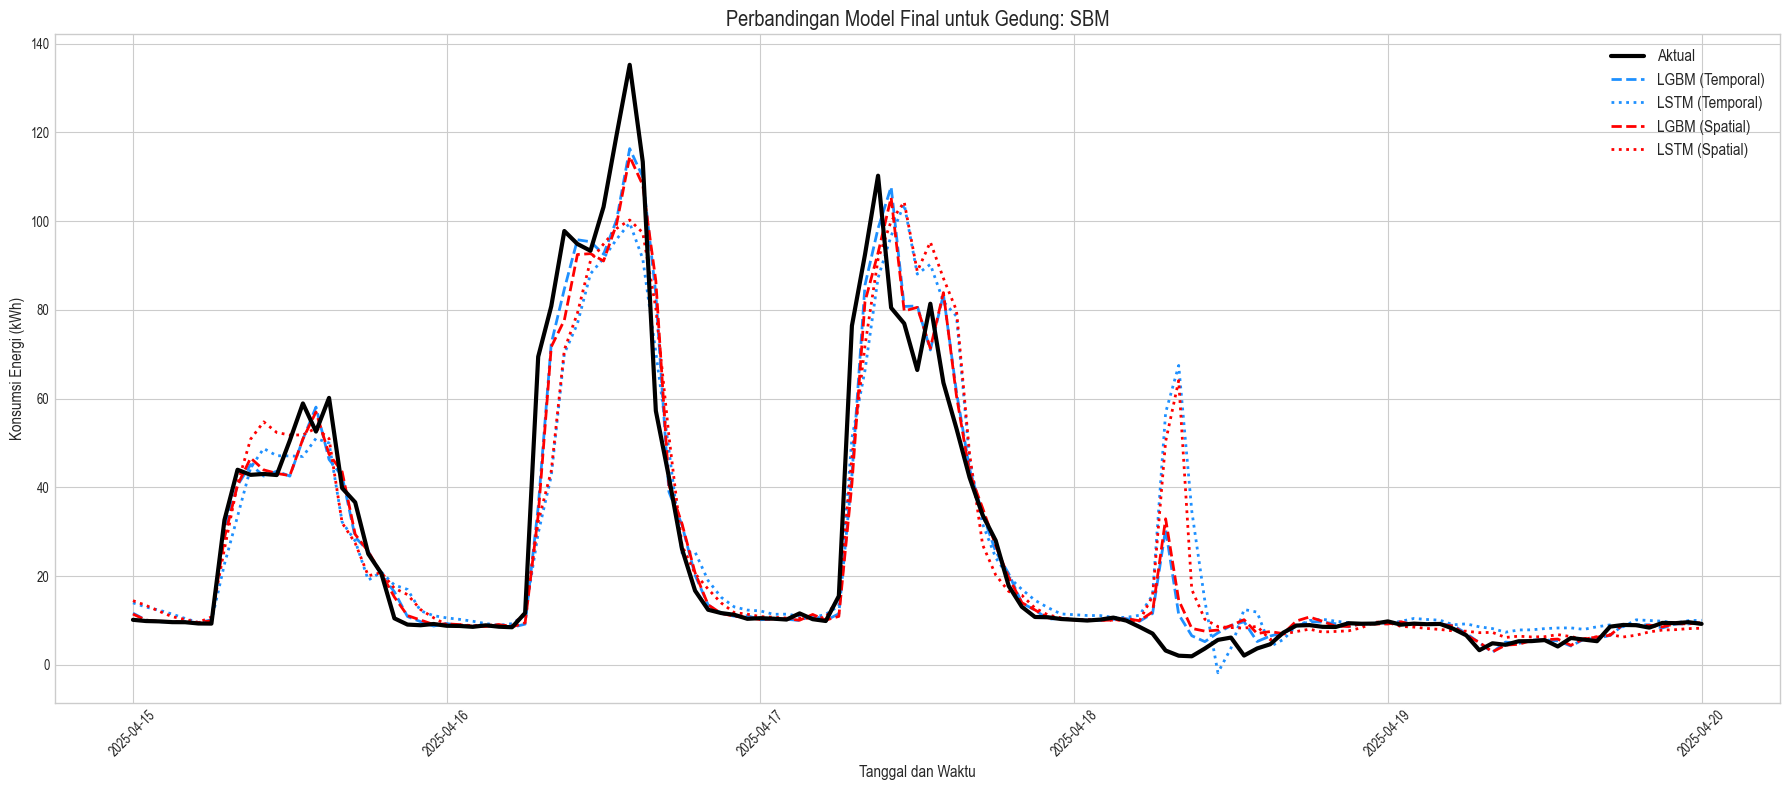

In [11]:
# =============================================================================
# --- Tahap 4: Visualisasi Perbandingan Hasil Prediksi ---
# =============================================================================

def plot_final_comparison(df, meter_id, start_date, end_date):
    """
    Membuat plot perbandingan untuk semua model.
    """
    plot_data = df[
        (df['meter_id'] == meter_id) &
        (df['timestamp'] >= start_date) &
        (df['timestamp'] <= end_date)
    ].copy()
    
    if plot_data.empty:
        print(f"Peringatan: Tidak ada data untuk {meter_id} pada rentang tanggal tersebut.")
        return
        
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(18, 8))
    
    # Plot data aktual
    plt.plot(plot_data['timestamp'], plot_data['target_aktual'], label='Aktual', color='black', linewidth=3, zorder=5)
    
    # Plot prediksi
    colors = {'temporal': 'dodgerblue', 'spatial': 'red'}
    styles = {'lgbm': '--', 'lstm': ':'}
    
    for model_name in dfs.keys():
        pred_col = f'prediksi_{model_name}'
        model_type, feature_type = model_name.split('_')
        
        if pred_col in plot_data.columns:
            plt.plot(
                plot_data['timestamp'], 
                plot_data[pred_col], 
                label=f"{model_type.upper()} ({feature_type.capitalize()})",
                color=colors[feature_type],
                linestyle=styles[model_type],
                linewidth=2
            )
            
    plt.title(f'Perbandingan Model Final untuk Gedung: {meter_id}', fontsize=16)
    plt.xlabel('Tanggal dan Waktu', fontsize=12)
    plt.ylabel('Konsumsi Energi (kWh)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Contoh Penggunaan Fungsi Visualisasi ---
print("\n--- Menampilkan Contoh Visualisasi Perbandingan ---")
plot_final_comparison(
    df=df_compare,
    meter_id='SBM',
    start_date='2025-04-15',
    end_date='2025-04-20'
)
